In [1]:
## import numpy as np # linear algebra
from matplotlib import pyplot as plt
#We need these in this file:
import sys
sys.path.append('cropping')
sys.path.append('scripts')
import load_read_name_extractor as lrne
import SVM_classifier_general as svm_general

#Taget fra længere nede i koden:
import torch
from torchvision import transforms
from PIL import Image
import random
import itertools
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import DeepFunctions as df
from random import shuffle
from torch.utils.data import Dataset, DataLoader, random_split
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from torchvision import transforms
from IPython.display import display
import os
import json
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
img_list, names = lrne.load_name_and_img("cropped_mean/*jpeg")

In [3]:
print(len(img_list))
print(len(names))

4915
4915


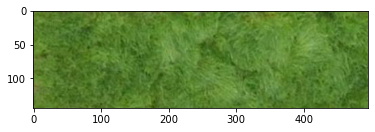

cropped_mean/191_210611_Min.jpeg


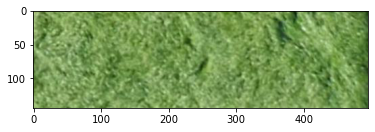

cropped_mean/124_200528_Min.jpeg


In [4]:
# pick a random index
random_index = random.randint(0, len(img_list)-1)

# get the corresponding image and name
random_img = img_list[random_index]
random_name = names[random_index]

# show the image and print the name
plt.imshow(random_img)
plt.show()
print(random_name)

# show the first image and print the name
plt.imshow(img_list[0])
plt.show()
print(names[0])


In [5]:
date_ = False
bin_size = 10
n_bins = int(np.floor(100/bin_size))
labels = svm_general.load_labels(bin_size, date_)
print(labels[0])
print(len(labels))

#convert names into [flight_folder, ROI]
names_labels = lrne.it_name_extract_labels_from_img_jpeg(names)
print(names_labels[0])
lodging_score = [[] for _ in range(4915)]

#match labels with feature names
lodging_score = svm_general.match_pic_label_to_names_new(lodging_score, labels, names_labels, date_)

['238' '0' '180514_Bj' '0']
4936
['124', '200528_Min']


In [6]:
lodging_score_int = [[int(char) for char in sublist] for sublist in lodging_score]
flattened_list = list(itertools.chain.from_iterable(lodging_score_int))
#print(flattened_list)
lodging_score = flattened_list
#print(max(lodging_score_int))
count_9 = lodging_score.count(9)
print(count_9)

print(np.shape(img_list))
print(np.shape(flattened_list))

1
(4915, 144, 496, 3)
(4915,)


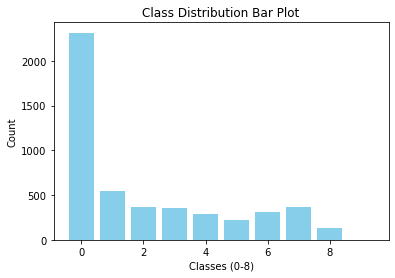

In [7]:
import matplotlib.pyplot as plt
from collections import Counter

class_counts = Counter(lodging_score)

# Create a bar plot
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')

# Add labels and title
plt.xlabel('Classes (0-8)')
plt.ylabel('Count')
plt.title('Class Distribution Bar Plot')

# Display the plot
plt.show()

In [8]:
class ImageDataset(Dataset):
    def __init__(self, img_list, lodging_score, transform=None):
        self.img_list = img_list
        self.lodging_score = lodging_score
        self.transform = transform
        self.mean = 0
        
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, idx):
        img = self.img_list[idx]
        score = self.lodging_score[idx]

        # Convert image to tensor and apply transformations
        if self.transform:
            img = self.transform(img)

        return img, score
    def get_labels(self):
        return self.lodging_score

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((144, 496)),
    #transforms.Grayscale(),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485], std=[0.229]),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

In [9]:

# Combine img_list and lodging_score
combined_data = list(zip(img_list, lodging_score))

# Shuffle the combined data
shuffle(combined_data)

# Unzip the shuffled data
img_list, lodging_score = zip(*combined_data)
dataSet = ImageDataset(img_list, lodging_score, transform=transform)
print(dataSet[0][1])
count_0 = lodging_score.count(0)
print(count_0)


0
2314


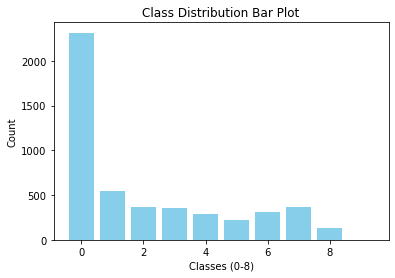

In [10]:
# Assuming dataSet is a list of tuples where the second element contains the classes
class_list = [item[1] for item in dataSet]

# Count occurrences of each class
class_counts = Counter(class_list)

# Create a bar plot
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')

# Add labels and title
plt.xlabel('Classes (0-8)')
plt.ylabel('Count')
plt.title('Class Distribution Bar Plot')

# Display the plot
plt.show()

In [11]:
print(len(dataSet[0]))
print(len(dataSet))
#print(type(dataSet[0][0]))


# Assuming img is a PIL.Image.Image object
display(dataSet[0][0].shape)

2
4915


torch.Size([3, 144, 496])

In [12]:
dataSet = df.filter_data(dataSet)
print(len(dataSet[0]))
print(len(dataSet))
print(dataSet[0][0].shape)

2
3100
torch.Size([3, 144, 496])


In [14]:
# Usage example
dataSet = df.augment_data(dataSet)
print(len(dataSet[0]))
print(len(dataSet))
print(dataSet[0][0].shape)

2
49600
torch.Size([3, 144, 496])


In [14]:
#Split into train and validation set
random_seed = 10587
testValSize = (2/5) * len(dataSet)
trainDataset, testvalDataset = train_test_split(dataSet, test_size=int(testValSize), random_state=random_seed, shuffle=True)
validationSize = (1/2) * len(testvalDataset)
testDataset, valDataset = train_test_split(testvalDataset, test_size=int(validationSize), random_state=random_seed, shuffle=True)

#Create dataloaders
batchSize = 64
trainDataloader = DataLoader(trainDataset, batch_size=batchSize, shuffle=True)
testDataloader = DataLoader(testDataset, batch_size=batchSize, shuffle=True)
valDataloader = DataLoader(valDataset, batch_size=batchSize, shuffle=True)

In [15]:
#Print sizes
print(len(trainDataloader), len(testDataloader), len(valDataloader))
print(dataSet[0][0].shape)

117 39 39
torch.Size([3, 144, 496])


In [16]:
torch.save(trainDataloader, 'data/train_loader.pth')
torch.save(testDataloader, 'data/val_loader.pth')
torch.save(valDataloader, 'data/test_loader.pth')


In [17]:
torch.save([len(trainDataset),len(testDataset), len(valDataset)], 'data/lengthsdataset.pth')